In [2]:
import numpy                as np
import matplotlib.pyplot    as plt
from astropy import units   as units
import datetime as dt
import sys
from pathlib            import Path
from matplotlib         import rcParams, rc
from scipy.interpolate  import interp1d
import types
# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
from src.read               import read_data_chemtorch
# from src.rates          import *
from src.solve_n_save       import solve_dg
from src.input              import density

rate = 16

outloc = '/lhome/silkem/ChemTorch/ChemTorch/out/'
samploc = '/lhome/silkem/ChemTorch/ChemTorch/sampling/'
dataloc = '/lhome/silkem/ChemTorch/PhantomSampling/'

## Getting sampling functions from Phantom distributions

In [2]:
def get_dist(nbins,file):
    data = np.loadtxt(dataloc+file+'.txt')
    out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)
    plt.title(file)
    plt.plot(out[1][:-1],out[0])
    # plt.xlim(-0.002, 0.0005)
    plt.show()
    return out


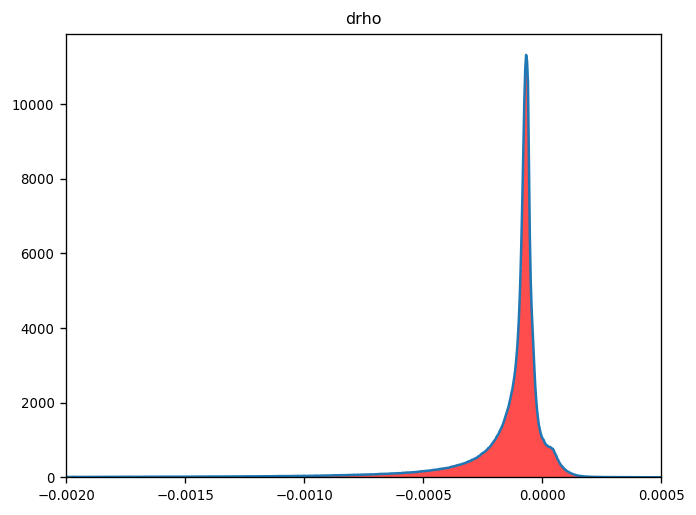

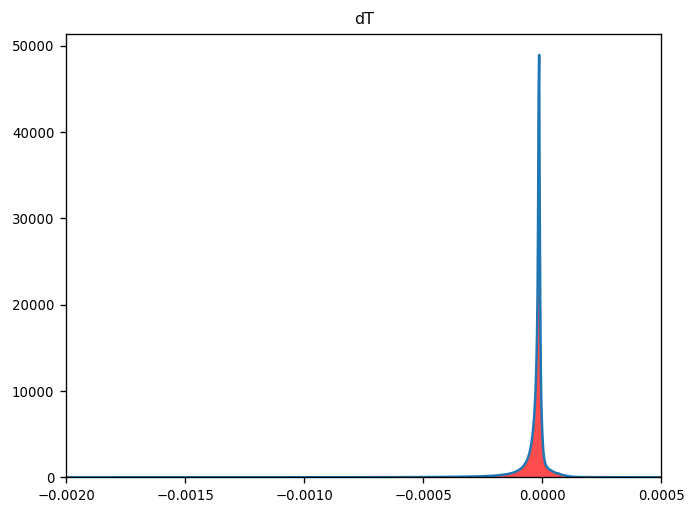

In [7]:
## diif density & temperature distributions

nbins = 100000
file = 'drho'
out_rho = get_dist(nbins, file)
file = 'dT'
out_temp = get_dist(nbins, file)


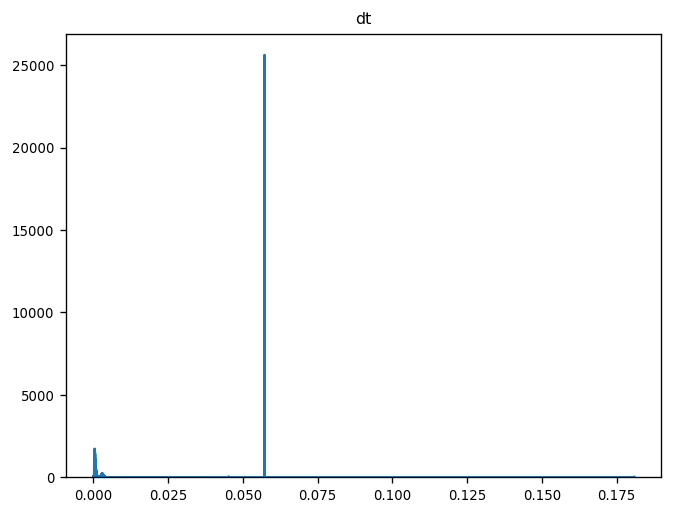

In [7]:
## dt distributions

nbins = 100000
dt1 = np.loadtxt(dataloc+'dtime1'+'.txt')
dt2 = np.loadtxt(dataloc+'dtime2'+'.txt')
dt3 = np.loadtxt(dataloc+'dtime3'+'.txt')
data = np.concatenate((dt1,dt2,dt3), axis = 0)

# print(data.shape)

out = plt.hist(data,bins=nbins, density=True, color='r', alpha=0.7)


In [16]:
print(np.log10(dt2))

[-0.74256143 -0.74256143 -0.74256143 ... -3.02323748 -3.14050144
 -3.12971317]


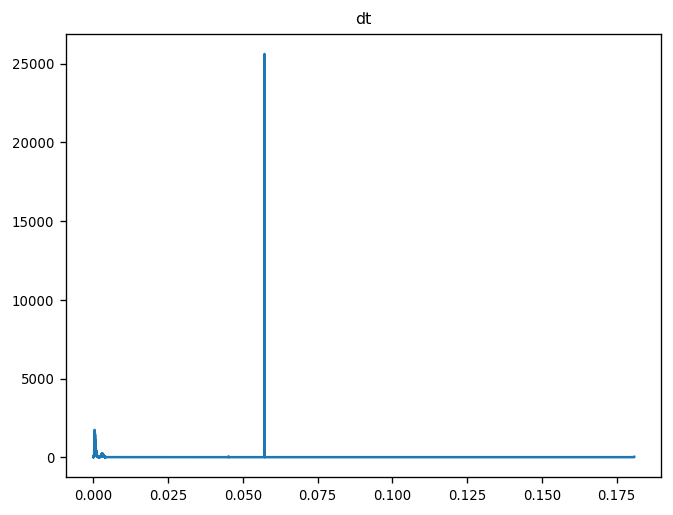

In [15]:
plt.title('dt')
plt.plot(out[1][:-1],out[0])
# plt.xlim(-0.002, 0.075)
# plt.yscale('log')
plt.show()

In [11]:
np.save(samploc+'drho', out_rho[0]) 
np.save(samploc+'dT', out_temp[0]) 

In [16]:
np.save(samploc+'drho_range', out_rho[1][:-1]) 
np.save(samploc+'dT_range', out_temp[1][:-1]) 

## Data generation


In [4]:
## Ranges from PHANTOM models
ρ_min = min(np.load(samploc+'drho_range.npy'))
ρ_max = max(np.load(samploc+'drho_range.npy'))
T_min = min(np.load(samploc+'dT_range.npy'))
T_max = max(np.load(samploc+'dT_range.npy'))
δ_min = 1.e-6
δ_max = 1
Av_min = -1
Av_max = -np.log(δ_max)
dt_min = 3.8
dt_max = 5.

nstep = 512

In [5]:
### !!! HIER VERONDERSTELLEN WE ONGECORRELEERDE PARAMETERS


def fdens(x):
	rho_func = np.load(samploc+'drho.npy') 
	return rho_func

def ftemp(x):
	T_func = np.load(samploc+'dT.npy') 
	return T_func

def fdelta(x):
	return np.ones_like(x)

def fAv(x):
	return np.ones_like(x)

def fdt(x):
	return x**3./(-1.+np.exp(-x+3.8001))

## cummulative sum 
## generate random numbers between [0,1)
## Define a function to return N samples
def genSamples(xmin, xmax, nstep, N, f):
	xbin = np.linspace(xmin, xmax, nstep)
	ycum = np.cumsum(f(xbin))
	xbin = np.linspace(xmin, xmax, len(ycum))
	u = np.random.uniform(ycum.min(), ycum.max(), int(N))
	## take the inverse of cumm. function
	func_interp = interp1d(ycum, xbin)
	samples = func_interp(u)
	return samples
	

def calc_next(f, param_i, min, max, nstep):
	N = 1
	ε = genSamples(min, max, nstep, N, f)
	# print(ε)
	param_next = (ε + 1)*param_i
	return param_next[0]

def next_input_idv(ρ, T, δ, Av):
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	return ρ_next, T_next, δ_next, Av_next

def next_input(input):
	ρ = input[0]
	T = input[1]
	δ = input[2]
	Av= input[3]
	ρ_next  = calc_next(fdens , ρ , ρ_min , ρ_max , nstep)
	T_next  = calc_next(ftemp , T , T_min , T_max , nstep)
	δ_next  = calc_next(fdelta, δ , δ_min , δ_max , nstep)
	Av_next = calc_next(fAv   , Av, Av_min, Av_max, nstep)
	# print(ρ_next.type)
	return [ρ_next, T_next, δ_next, Av_next]

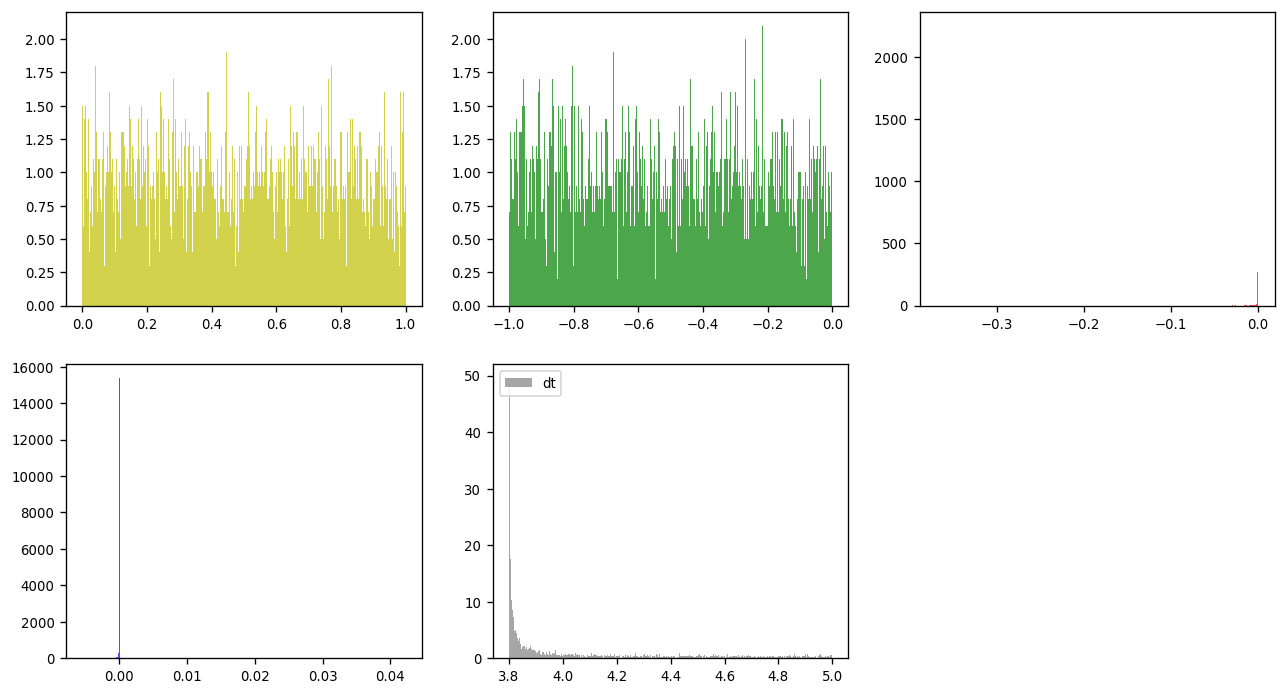

In [8]:
nsamples = 1.e4
nbins = 1000

dens_samples = genSamples(ρ_min, ρ_max, nstep, nsamples, fdens)
temp_samples = genSamples(T_min, T_max, nstep, nsamples, ftemp)
delt_samples = genSamples(δ_min, δ_max, nstep, nsamples, fdelta)
Av_samples = genSamples(Av_min, Av_max, nstep, nsamples, fAv)
dt_samples = genSamples(dt_min, dt_max, nstep, nsamples, fdt)

fig = plt.figure(figsize=(13,7))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(234)
ax5 = plt.subplot(235)

ax1.hist(delt_samples,bins=nbins, density=True, color='y', alpha=0.7, label = 'delta')
ax2.hist(Av_samples  ,bins=nbins, density=True, color='g', alpha=0.7, label = 'Av')
ax3.hist(dens_samples,bins=nbins, density=True, color='r', alpha=0.7, label = 'density')
ax4.hist(temp_samples,bins=nbins, density=True, color='b', alpha=0.7, label = 'temp')
ax5.hist(dt_samples  ,bins=nbins, density=True, color='grey', alpha=0.7, label = 'dt')

plt.legend(loc = 'upper left')
plt.show()

In [6]:
ρ_i  = 1.13E+05
T_i  = 2500
δ_i  = 1.e-1
Av_i = -np.log(1.e-3)

ρ, T, δ, Av = next_input_idv(ρ_i, T_i, δ_i, Av_i)
# print('')
ρ2, T2, δ2, Av2 = next_input_idv(ρ, T, δ, Av)
# print('')
ρ3, T3, δ3, Av3 = next_input_idv(ρ2, T2, δ2, Av2)
# print('')
ρ4, T4, δ4, Av4 = next_input_idv(ρ3, T3, δ3, Av3)

print('')
print('density',ρ_i, ρ, ρ2, ρ3, ρ4)
print('temp   ',T_i, T, T2, T3, T4)
print('delta  ',δ_i, δ, δ2, δ3, δ4)
print('Av     ',Av_i, Av, Av2, Av3, Av4)



density 113000.0 112997.50678500858 112975.33996817983 112962.47891209854 112938.55818845922
temp    2500 2499.875687974511 2499.7438610433805 2499.71025304774 2499.766140453778
delta   0.1 0.1408686481929484 0.25378001593929683 0.300965844843558 0.37607914945336085
Av      6.907755278982137 1.2824374726342334 0.028916157609862353 0.02633890931276555 0.00837527886727312


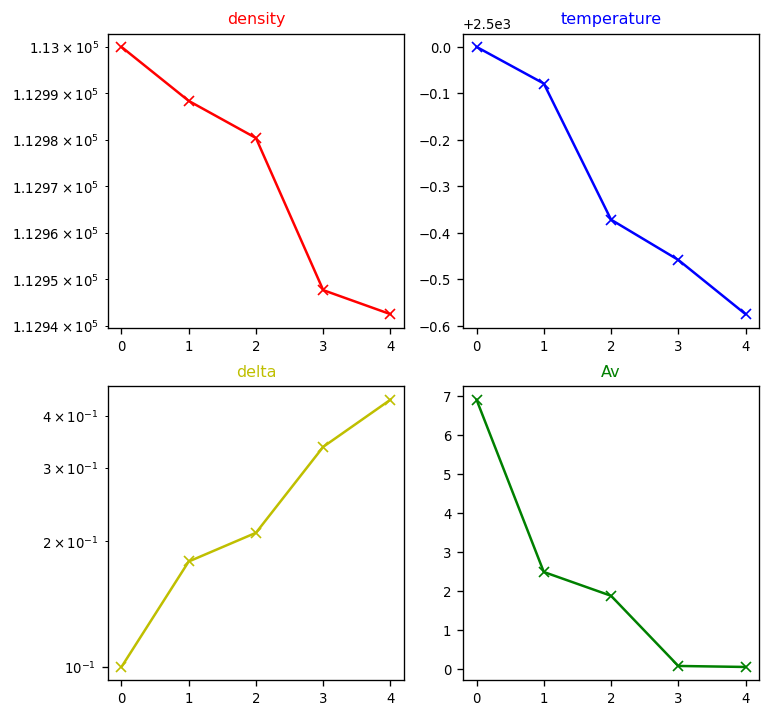

In [10]:
fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [1,1]},figsize=(7, 7))
ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]
x = [0,1,2,3,4]

ax1.plot(x,np.array([ρ_i, ρ[0], ρ2[0], ρ3[0], ρ4[0]]), 'x-',c='r')
ax2.plot(np.array([T_i, T[0], T2[0], T3[0], T4[0]]), 'x-', c='b')
ax3.plot(np.array([δ_i, δ[0], δ2[0], δ3[0], δ4[0]]), 'x-', c = 'y')
ax4.plot(np.array([Av_i, Av[0], Av2[0], Av3[0], Av4[0]]), 'x-', c= 'g')

ax1.set_title('density', color='r')
ax2.set_title('temperature', color='b')
ax3.set_title('delta', color = 'y')
ax4.set_title('Av', color = 'g')

ax1.set_yscale('log')
ax3.set_yscale('log')



In [8]:
# elke run eigen map, uniek, date ofzo
# checken op andere computer dat wanneer ge random seeds maakt, dat de random getallen effectief anders zijn
# nu enkel variaties van variabelen, begin met een gekozen input
# starten van de chemie waar ge mee eindigd --> paden in de fysiochemische ruimte
# eind abundantie terug meegeven, niet initialiseren

In [7]:
import src.rates        as rates

chemtype = 'C'

## set initial conditions
n, nconsv_tot, specs, nshield_i = rates.initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code

ρi  = 1.13E+05
Ti  = 2500
δi  = 1.e-1
Avi = -np.log(1.e-3)
input = [ρi,Ti,δi,Avi]

Δt =  10**genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec

nf = solve_dg(input, Δt, rate, n, nshield_i, nconsv_tot)
    

------------------------------------------------------------------------------
Name:
2023-08-03 03:47:21.960973

Input:
[density, temperature, delta, Av] dt:
[113000.0, 2500, 0.1, 6.907755278982137] 18068.02

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 18068.0207 yr...
The solver successfully reached the end of the integration interval.
DONE! In 4.63 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-03 03:47:21.960973/
------------------------------------------------------------------------------


In [8]:
nf.shape

(466,)

In [8]:
input2 = next_input(input)
Δt =  10**genSamples(dt_min, dt_max, nstep, 1, fdt)[0]     ## sec
nf2 = solve_dg(input2, Δt, rate, nf, nshield_i, nconsv_tot)

------------------------------------------------------------------------------
Name:
2023-08-03 03:47:37.995543

Input:
[density, temperature, delta, Av] dt:
[112982.45350339616, 2499.9906491177153, 0.16216342399555062, 2.108582679050232] 22666.14

 >> Calculate chemical rates...
DONE!

 >> Solving ODE for Δt = 22666.14 yr...
The solver successfully reached the end of the integration interval.
DONE! In 4.68 seconds.

 >> Saving output...
DONE! Output found in ../out/2023-08-03 03:47:37.995543/
------------------------------------------------------------------------------


In [9]:

path = '/lhome/silkem/ChemTorch/ChemTorch/out/2023-08-03 03:47:37.995543/'

print(np.load(path+'input.npy'))
print(np.load(path+'tictoc.npy'))
print(np.load(path+'abundances.npy'))

[1.12982454e+05 2.49999065e+03 1.62163424e-01 2.10858268e+00
 2.26661400e+04]
[4.68469191 0.11098218]
[[1.69674161e-13 1.49415361e-12]
 [2.61839287e-15 5.90208592e-15]
 [3.52241592e-17 7.93935692e-17]
 [4.45690690e-14 5.00652550e-14]
 [6.33034023e-14 1.93030335e-13]
 [8.50000000e-02 8.50000000e-02]
 [9.97425926e-15 2.24633592e-14]
 [3.98933559e-16 6.76040193e-16]
 [4.70929243e-32 6.88220240e-31]
 [6.56339628e-18 3.31098450e-17]
 [2.38934807e-13 6.55776819e-13]
 [9.01872604e-35 2.80053965e-33]
 [1.80579679e-19 7.67181998e-19]
 [6.91960363e-16 3.60389510e-15]
 [6.38770899e-20 3.95956184e-19]
 [1.55940881e-19 5.77409453e-19]
 [1.01898308e-15 1.31094539e-14]
 [4.69778170e-16 4.26234591e-15]
 [2.95145946e-18 2.26868746e-15]
 [4.10719188e-18 1.56955442e-16]
 [3.85771983e-20 2.36098569e-19]
 [2.86997523e-19 1.26003831e-18]
 [4.61108972e-21 1.48167237e-20]
 [1.35289328e-20 1.92209736e-19]
 [1.54915342e-19 2.16446345e-15]
 [2.57032065e-32 3.27715854e-31]
 [9.25145812e-18 5.04717693e-16]
 [2.328